# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 100
import seaborn as sns

sns.set()
from tqdm import tqdm
from IPython.display import Image

from src.space.utils import get_coord_matrix, get_affine_transform
from src.model.gmu_social import GmuSocial
from src.visualization.utils import plot_commuter_status_count, plot_num_friendships

## Load vector data

In [2]:
gmu_social_model = GmuSocial(
    gmu_buildings_file="../data/raw/campus/Mason_bld.shp",
    gmu_walkway_file="../data/raw/campus/Mason_walkway_line.shp",
    world_size_file="../data/raw/campus/world.shp",
    num_commuters=109,
)
gmu_social_model.gmu_buildings

/Users/boyu/GitHubProjects/gmu-social-in-python/src/model/gmu_social.py:91: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  self.gmu_buildings["centroid"] = self.gmu_buildings["geometry"].centroid


,NAME,function,geometry,centroid,centroid_transformed
Id,,,,,
1,GEORGE W. JOHNSON CENTER,1.0,"POLYGON ((11822517.11166 6987684.10842, 118225...",POINT (11822640.59876 6987512.56961),POINT (23.15821 17.14446)
2,DAVID KING HALL,1.0,"POLYGON ((11822800.55434 6987724.17504, 118227...",POINT (11822864.48326 6987750.86550),POINT (26.33261 20.25395)
3,SCIENCE AND TECH I,1.0,"POLYGON ((11823106.15955 6987428.08606, 118230...",POINT (11823017.54177 6987488.48250),POINT (28.50279 16.83015)
4,SCIENCE AND TECH II,1.0,"POLYGON ((11823144.77700 6987485.86687, 118231...",POINT (11823215.09805 6987415.04893),POINT (31.30389 15.87192)
5,ENTERPRISE HALL,1.0,"POLYGON ((11822946.56417 6987144.44857, 118229...",POINT (11823075.80655 6987192.06649),POINT (29.32891 12.96224)
...,...,...,...,...,...
57,CROSS COTTAGE,0.0,"POLYGON ((11821649.40986 6987068.51409, 118216...",POINT (11821650.18988 6987061.54372),POINT (9.11544 11.25907)
58,CENTER FOR STUDENT ENGAGEMENT (SUB II),0.0,"POLYGON ((11823355.05141 6987869.56873, 118233...",POINT (11823386.85056 6987773.89599),POINT (33.73913 20.55448)
59,SANDY CREEK PARKING DECK,0.0,"POLYGON ((11823486.80798 6987357.73456, 118234...",POINT (11823535.36021 6987128.52445),POINT (35.84481 12.13309)


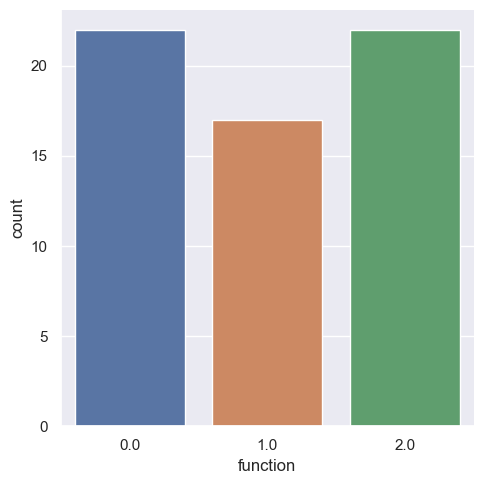

In [3]:
# following the netlogo model, fill na with 0.0
sns.catplot(
    x="function",
    data=gmu_social_model.gmu_buildings.sort_values(by="function").fillna("missing"),
    kind="count",
)

In [4]:
gmu_social_model.gmu_walkway

,geometry,geometry_transformed
Id,,
0,"LINESTRING (11822464.14699 6988476.89551, 1182...","LINESTRING (20.65634 29.72784, 22.49900 26.66623)"
0,"LINESTRING (11822594.10614 6988242.26927, 1182...","LINESTRING (22.49900 26.66623, 22.92423 25.883..."
0,"LINESTRING (11822329.18942 6988193.98445, 1182...","LINESTRING (18.74281 26.03617, 21.88950 27.65372)"
0,"LINESTRING (11822698.07345 6987962.35727, 1182...","LINESTRING (23.97313 23.01369, 23.93060 22.885..."
0,"LINESTRING (11822695.07439 6987952.56035, 1182...","LINESTRING (23.93060 22.88585, 23.51955 21.76530)"
...,...,...
0,"LINESTRING (11823370.26496 6987341.02044, 1182...","LINESTRING (33.50396 14.90593, 33.03336 14.652..."
0,"LINESTRING (11823370.26496 6987341.02044, 1182...","LINESTRING (33.50396 14.90593, 33.71492 15.070..."
0,"LINESTRING (11822149.47828 6987062.23034, 1182...","LINESTRING (16.19473 11.26803, 16.48335 10.670..."


In [5]:
gmu_social_model.world_size

,geometry
Id,
0,"POLYGON ((11821007.29556 6989187.46574, 118265..."


## Affine transformation

The transformation is already done in the model constructor.

In [6]:
gmu_social_model.world_size.envelope

Id
0    POLYGON ((11821007.29556 6986198.70691, 118265...
dtype: geometry

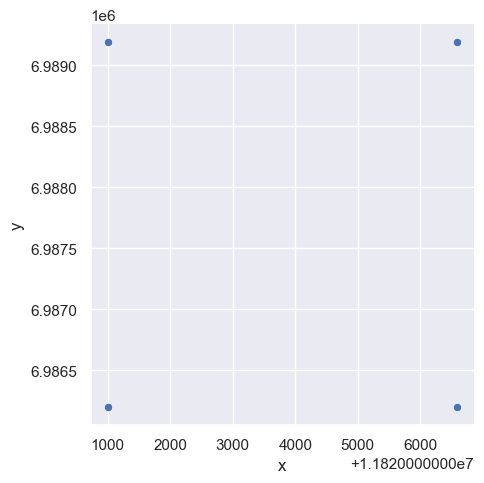

In [7]:
world_envelope_df = pd.DataFrame(
    [
        (x, y)
        for x, y in zip(*gmu_social_model.world_size.envelope[0].exterior.coords.xy)
    ],
    columns=["x", "y"],
)
assert len(world_envelope_df) == 5
np.testing.assert_array_equal(
    world_envelope_df.iloc[0].values, world_envelope_df.iloc[-1].values
)  # first and last points are the same in the envelope polygon
world_envelope_df = world_envelope_df[:-1]  # remove last point which is redundant

sns.relplot(x="x", y="y", data=world_envelope_df, kind="scatter")

In [8]:
world_envelope_coords = get_coord_matrix(
    x_min=world_envelope_df["x"].min(),
    x_max=world_envelope_df["x"].max(),
    y_min=world_envelope_df["y"].min(),
    y_max=world_envelope_df["y"].max(),
)
world_envelope_coords

array([[1.18210073e+07, 6.98619871e+06, 1.00000000e+00],
       [1.18210073e+07, 6.98918747e+06, 1.00000000e+00],
       [1.18265790e+07, 6.98619871e+06, 1.00000000e+00],
       [1.18265790e+07, 6.98918747e+06, 1.00000000e+00]])

In [9]:
netlogo_min_pxcor, netlogo_max_pxcor = 0, 79
netlogo_min_pycor, netlogo_max_pycor = 0, 39
netlogo_world_coords = get_coord_matrix(
    x_min=netlogo_min_pxcor,
    x_max=netlogo_max_pxcor,
    y_min=netlogo_min_pycor,
    y_max=netlogo_max_pycor,
)
netlogo_world_coords

array([[ 0.,  0.,  1.],
       [ 0., 39.,  1.],
       [79.,  0.,  1.],
       [79., 39.,  1.]])

In [10]:
affine_transform = get_affine_transform(
    from_coord=world_envelope_coords, to_coord=netlogo_world_coords
)
affine_transform

(0.014178754839110306,
 4.0939474033052647e-16,
 -1.8492542826979613e-15,
 0.01304889498301628,
 -167607.16439505797,
 -91162.17325698886)

In [11]:
# transformed in the model constructor
gmu_social_model.gmu_buildings["centroid_transformed"]

Id
1     POINT (23.15821 17.14446)
2     POINT (26.33261 20.25395)
3     POINT (28.50279 16.83015)
4     POINT (31.30389 15.87192)
5     POINT (29.32891 12.96224)
                ...            
57     POINT (9.11544 11.25907)
58    POINT (33.73913 20.55448)
59    POINT (35.84481 12.13309)
60    POINT (36.23473 32.05987)
61    POINT (32.46589 34.10442)
Name: centroid_transformed, Length: 61, dtype: geometry

In [12]:
# transformed in the model constructor
gmu_social_model.gmu_walkway["geometry_transformed"]

Id
0    LINESTRING (20.65634 29.72784, 22.49900 26.66623)
0    LINESTRING (22.49900 26.66623, 22.92423 25.883...
0    LINESTRING (18.74281 26.03617, 21.88950 27.65372)
0    LINESTRING (23.97313 23.01369, 23.93060 22.885...
0    LINESTRING (23.93060 22.88585, 23.51955 21.76530)
                           ...                        
0    LINESTRING (33.50396 14.90593, 33.03336 14.652...
0    LINESTRING (33.50396 14.90593, 33.71492 15.070...
0    LINESTRING (16.19473 11.26803, 16.48335 10.670...
0    LINESTRING (30.39397 35.91656, 31.17590 35.844...
0    LINESTRING (31.51035 12.41587, 31.52921 12.376...
Name: geometry_transformed, Length: 201, dtype: geometry

# Run model

In [13]:
gmu_social_model = GmuSocial(
    gmu_buildings_file="../data/raw/campus/Mason_bld.shp",
    gmu_walkway_file="../data/raw/campus/Mason_walkway_line.shp",
    world_size_file="../data/raw/campus/world.shp",
    num_commuters=109,
    speed=5,
)

for _ in tqdm(range(1152)):  # 4 days
    gmu_social_model.step()

model_vars_df = gmu_social_model.datacollector.get_model_vars_dataframe()
model_vars_df.head()

/Users/boyu/GitHubProjects/gmu-social-in-python/src/model/gmu_social.py:91: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  self.gmu_buildings["centroid"] = self.gmu_buildings["geometry"].centroid
100%|██████████| 1152/1152 [00:10<00:00, 106.83it/s]


,time,status_home,status_work,status_traveling,friendship_home,friendship_work
0,0 days 05:55:00,109,0,0,695,0
1,0 days 06:00:00,108,0,1,695,0
2,0 days 06:05:00,104,0,5,695,0
3,0 days 06:10:00,101,4,4,695,0
4,0 days 06:15:00,97,4,8,695,0


# Visualize results

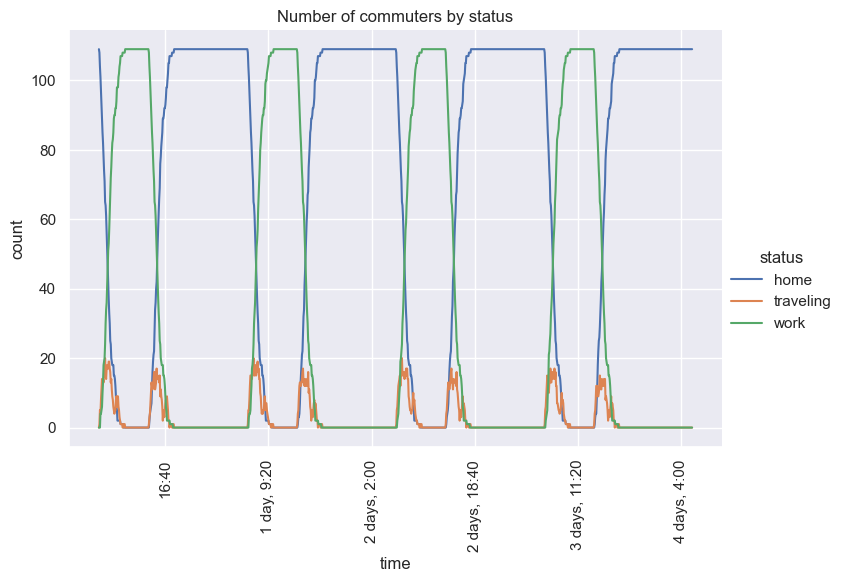

In [14]:
plot_commuter_status_count(model_vars_df)

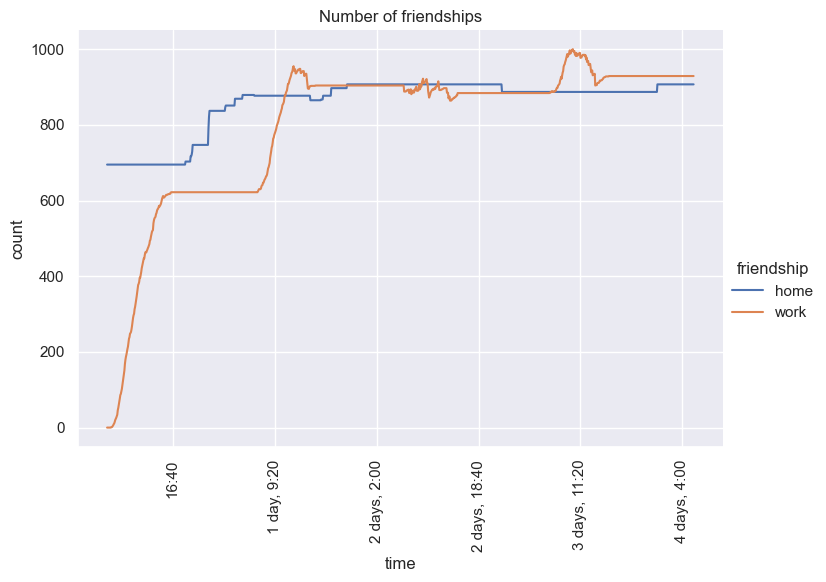

In [15]:
plot_num_friendships(model_vars_df)

# Running time

## Without caching path select results

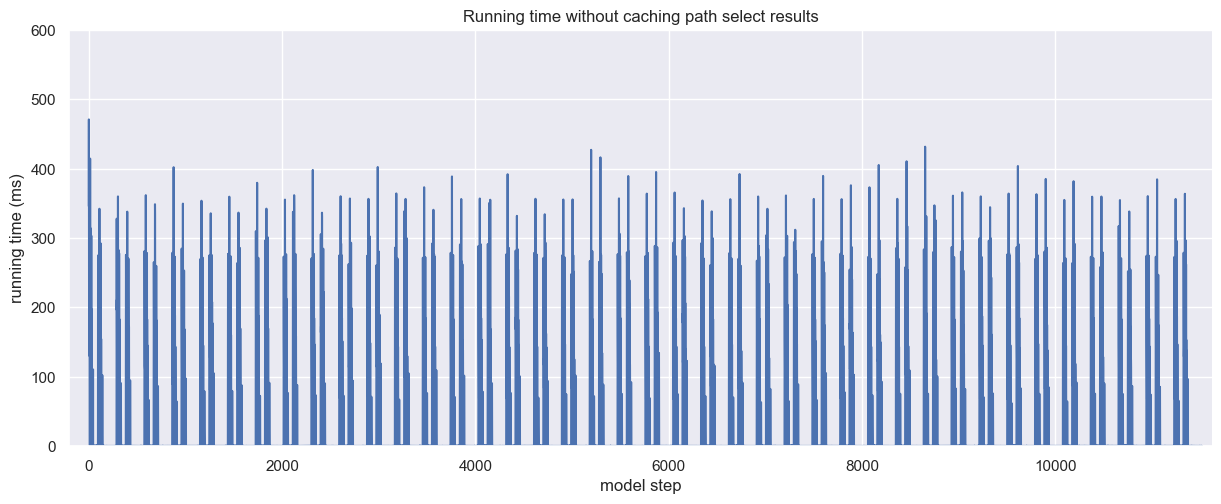

In [16]:
Image("../outputs/figures/runtime_without_caching_paths.png")

## With caching path select results

/Users/boyu/GitHubProjects/gmu-social-in-python/src/model/gmu_social.py:91: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  self.gmu_buildings["centroid"] = self.gmu_buildings["geometry"].centroid
100%|██████████| 11520/11520 [00:23<00:00, 494.95it/s] 


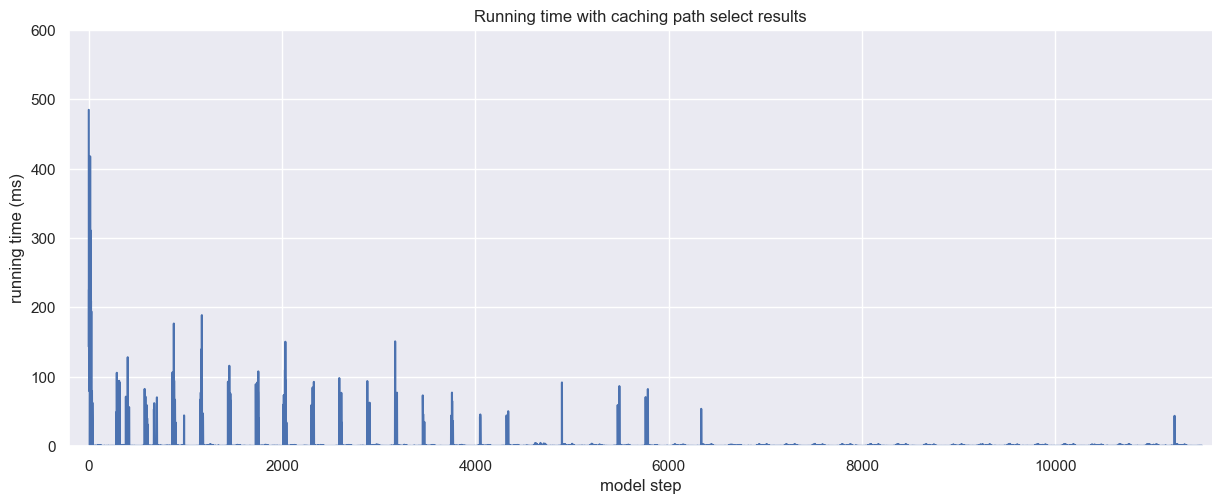

In [17]:
import time


gmu_social_model = GmuSocial(
    gmu_buildings_file="../data/raw/campus/Mason_bld.shp",
    gmu_walkway_file="../data/raw/campus/Mason_walkway_line.shp",
    world_size_file="../data/raw/campus/world.shp",
    num_commuters=109,
    speed=5,
)

runtime_no_cache = []
for _ in tqdm(range(11520)):
    start_time = time.time()
    gmu_social_model.step()
    runtime_no_cache.append(time.time() - start_time)

runtime_no_cache_df = pd.DataFrame(
    {
        "running time (ms)": np.array(runtime_no_cache) * 1e3,
        "model step": np.arange(len(runtime_no_cache)),
    }
)
sns.relplot(
    x="model step",
    y="running time (ms)",
    data=runtime_no_cache_df,
    kind="line",
    aspect=2.5,
    height=5,
)
plt.xlim([-200, len(runtime_no_cache) + 100])
plt.ylim([0.0, 600.0])
plt.title("Running time with caching path select results")

plt.savefig(
    "../outputs/figures/runtime_with_caching_paths.png", dpi=100, bbox_inches="tight"
)